**Name: Jingyi Xu**

# Summary of the SuSiE method

The **SuSiE** (_Sum of Single Effects_) method is a novel approach to variable selection in linear regression, particularly designed to quantify uncertainty in the selection of variables when some variables are highly correlated. The primary goal is to report as many **credible sets** (_a level ρ credible set is defined to be a subset of variables that has probability ρ or greater of containing at least one effect variable_) as the data support, each with as few variables as possible. Advanced from the **SER** (_single effects regression_) model, it operates by modeling the overall effect vector of regression coefficients as a sum of single-effect vectors, where each vector contains only one non-zero element. This structure allows for a simple and iterative fitting procedure known as iterative Bayesian stepwise selection (IBSS), which is a Bayesian version of traditional stepwise selection methods. Unlike conventional methods that select a single best variable at each step, SuSiE computes a distribution over potential variables, capturing the uncertainty associated with variable selection. This approach not only maintains computational simplicity and speed but also provides a credible set of variables for each selection, enhancing the interpretability of results. SuSiE is particularly effective in scenarios where variables are highly correlated and the detectable effects are sparse, making it well-suited for applications in genetic fine mapping.

# Overview

This fine-mapping tutorial was developed using simulated data shipped with [`susieR`](https://github.com/stephenslab/susieR) package.
The simulated data contains simulated phenotype matrix $Y$ in $N \approx 600$ individuals. 
The goal is to identify from the genotype matrix $X_{N\times P}$ ($P=1000$) the genetic variables that directly cause changes in the phenotypic values.

**There are several questions throughout the notebook, and please answer each of them by adding cells (in Markdown or R) under the question and keep the code you use there as well.**

The simulated data-set is [available
here](https://github.com/stephenslab/susieR/blob/master/data/N3finemapping.RData),
as part of the `susieR` package. In this tutorial we will first explore the data with conventional univariate association analysis,
then perform preliminary fine-mapping analysis under simplified 
assumptions to illustrate the idea of statistical fine-mapping, and finally use the R package `susieR` to perform formal Bayesian fine-mapping analysis.
We will also discuss fine-mapping using association summary statistics.

# Explore the association data-set

First let's install the package `susieR` according to [its Github repo](https://github.com/stephenslab/susieR) and `corrplot` to draw some plots later. This may take a while.

In [1]:
install.packages("susieR")
install.packages("corrplot")

also installing the dependencies 'irlba', 'RcppArmadillo', 'mixsqp', 'reshape'





The downloaded binary packages are in
	/var/folders/f9/1k8_8ryd75b1wll9n2_t2jqc0000gn/T//RtmpFkynhH/downloaded_packages

The downloaded binary packages are in
	/var/folders/f9/1k8_8ryd75b1wll9n2_t2jqc0000gn/T//RtmpFkynhH/downloaded_packages


Please execute the following code cell to load the simulated data.

In [2]:
rm(list=ls())
library(susieR)
library(corrplot)
data(N3finemapping)
attach(N3finemapping)

corrplot 0.94 loaded



In [2]:
ls()

[1] "N3finemapping"

The loaded dataset, `N3finemapping`, contains regression data $X$ and $Y$, 
along with some other relevant attributes in the context of genetic studies. It also
contains the "true" regression coefficients the data is simulated from.

In [3]:
names(N3finemapping)

[1] "X"                 "chrom"             "pos"              
[4] "true_coef"         "residual_variance" "Y"                
[7] "allele_freq"       "V"

In [4]:
dim(X)
head(X)

[1]  574 1001

-0.02090592,0.4738676,0.1620209,-0.05226481,-0.1637631,-0.026472457,0.1689895,-0.2421603,0.1585366,-0.1567944,...,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308
-0.02090592,-0.5261324,1.1620209,-0.05226481,-0.1637631,0.006059281,1.1689895,-0.2421603,1.1585366,-0.1567944,...,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308
-0.02090592,-0.5261324,1.1620209,-0.05226481,-0.1637631,-0.026472457,1.1689895,-0.2421603,1.1585366,-0.1567944,...,0.5993031,-0.09254036,0.5880654,-0.2857143,-0.3885017,-0.3919861,0.6030205,-0.02090592,-0.2844549,-0.3883308
-0.02090592,0.4738676,0.1620209,-0.05226481,-0.1637631,-0.026472457,0.1689895,-0.2421603,0.1585366,-0.1567944,...,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308
-0.02090592,-0.5261324,1.1620209,-0.05226481,-0.1637631,-0.026472457,1.1689895,-0.2421603,1.1585366,-0.1567944,...,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308
-0.02090592,-0.5261324,0.1620209,-0.05226481,-0.1637631,-0.026472457,0.1689895,0.7578397,0.1585366,-0.1567944,...,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308


-----------------------------------------

**Example question: in the genotype matrix `X`, how many individuals and the genetic variants are included? What is the genotype value for the 100th variant of the 21st individual?**

**Example answer:** The genotype matrix has 574 individuals and 1001 genetic variants. The genotype value for the 100th variant of the 21st individual is 0.4408.

In [5]:
dim(X)

[1]  574 1001

In [6]:
X[21, 100]

[1] 0.4407666

-----------------------------------------

The phenotype matrix contains values for the 574 individuals for 2 traits,

In [7]:
dim(Y)

[1] 574   2

We focus on the first trait, let

In [4]:
y = Y[,1]
b = true_coef[,1]

There are 3 "causal" variants for this trait,

In [9]:
which(b != 0)

[1] 403 653 773

Note: in this tutorial we will avoid the phrase "causal", and use "effect variable" to refer to the variants having true non-zero effects on the phenotype.

-----------------------------------------

**Question 1: Please use R function `plot` to visualize the true effects vector. What are the effect sizes for these 3 "causal" variants?**

**Answer:**

The effect sizes for the 3 effect variables are: 1.1891722992041, -0.831788980799581, 1.39928773430517

[1]  1.189172 -0.831789  1.399288

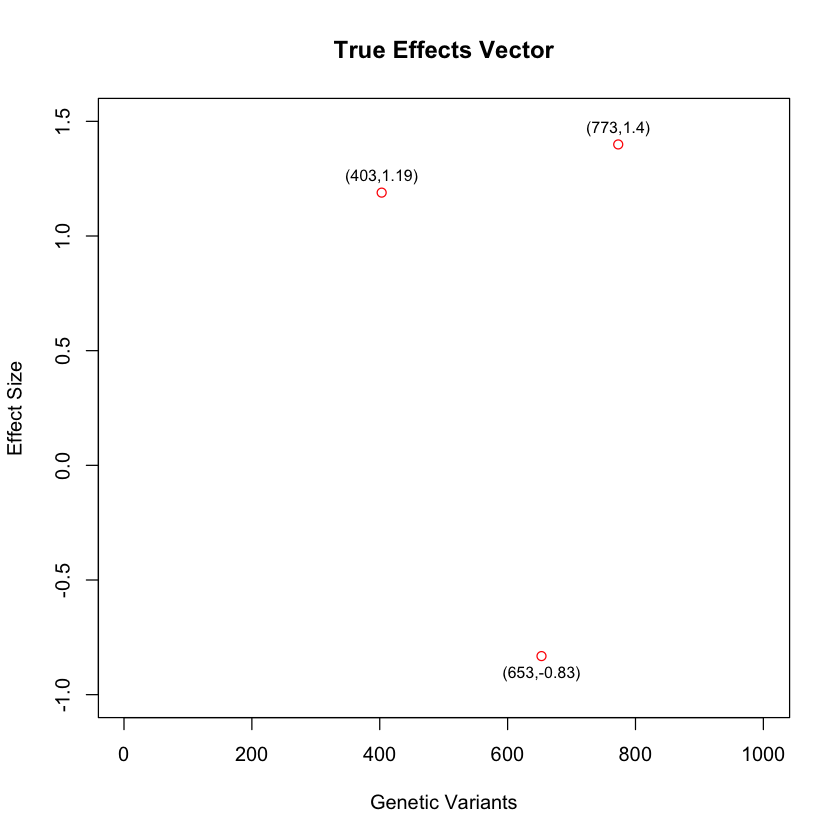

In [5]:
causal_set = which(b != 0)
b[causal_set]
plot(x=causal_set, y = b[causal_set], main = "True Effects Vector", xlab = "Genetic Variants", ylab = "Effect Size", col = "red", xlim = c(0,1001), ylim = c(-1,1.5))
text(x = causal_set, y = b[causal_set], 
     labels = paste("(", causal_set, ",", round(b[causal_set], 2), ")", sep = ""), 
     pos = ifelse(b[causal_set] >= 0, 3, 1), cex = 0.8, col = "black")

-----------------------------------------

# Association testing via simple linear regression

`univariate_regression` function in `susieR` can be used to perform association testing 
by fitting univariate simple regression for each variable separately.
The results are $\hat{\beta}$ for effect size estimates, and their standard errors $SE(\hat{\beta})$.

In [6]:
sumstats <- univariate_regression(X, y)

-----------------------------------------

**Question 2: Please use R function plot to compare the true effects variable `b` with the estimated effect sizes `sumstats$betahat`. Are they consistent, and why?**

**Answer:**

They are not consistent. Univariate regression only uses one variable to estimate y at a time. Because it fails to take the correlation between variables into consideration, the estimated effect sizes deviates from the true coefficients.

[1]  1.285890 -1.126053  1.421208

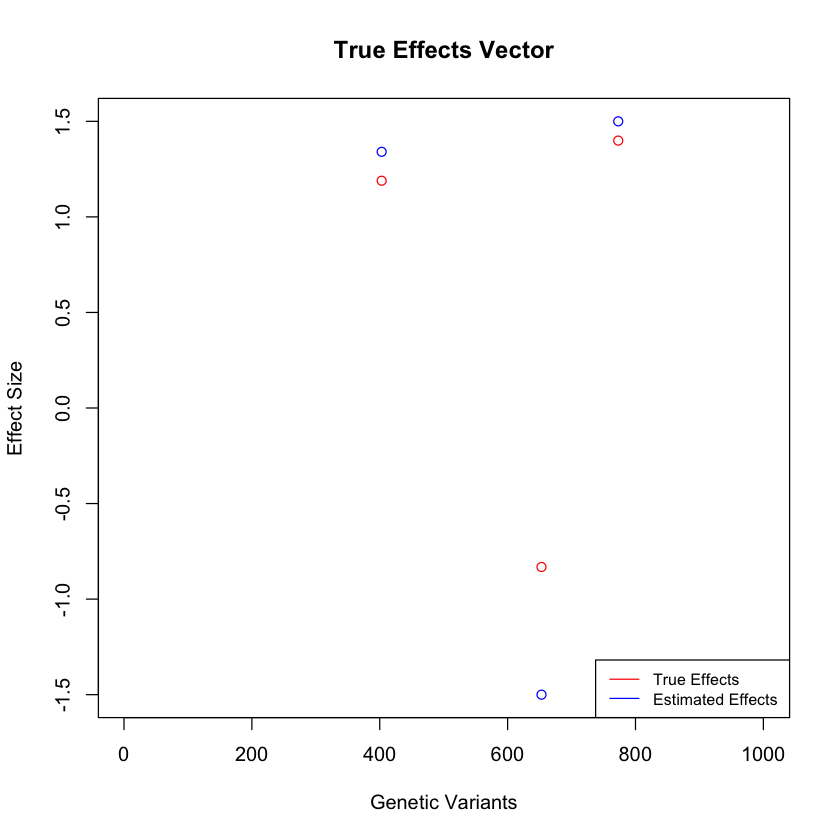

In [7]:
sumstats$beta[causal_set]
plot(x=causal_set, y = b[causal_set], main = "True Effects Vector", xlab = "Genetic Variants", ylab = "Effect Size", col = "red", xlim = c(0,1001), ylim = c(-1.5,1.5))
par(new=TRUE)
plot(x = causal_set, y = sumstats$beta[causal_set], axes = FALSE,xlab = "", ylab = "", col = "blue", xlim = c(0,1001))
legend("bottomright", legend = c("True Effects", "Estimated Effects"), col = c("red", "blue"), lty = 1, cex = 0.8)

-----------------------------------------

z-scores can be derived from these quantities; $-log_{10}$ p-values can then becomputed from z-scores, 

In [8]:
z_scores <- sumstats$betahat / sumstats$sebetahat
log10p <- -log10(pchisq(z_scores^2,1,lower.tail=F))

-----------------------------------------

**Question 3: How many variables have p-values smaller than $5 \times 10^{-8}$? How would you interpret those variants based on the univariate association analysis?**


**Answer:**

8 variables have p-values smaller than $5 \times 10^{-8}$.

Based on the univariate association analysis, the variants with p-values smaller than  $5 \times 10^{-8}$ show a statistically significant association with the phenotype. This suggests that these genotypes may have an influential role in the phenotype of interest. While these variants appear to have a strong association with the trait, it’s important to note that this univariate approach only evaluates each variant independently. Thus, potential interactions or combined effects of multiple variants may be overlooked.

In [9]:
p_thres <- -log10(5 * 10**(-8))
sum(log10p > p_thres)
which(log10p > p_thres)

[1] 8

[1] 653 666 667 773 776 777 794 800

**Question 4: What's the correlation between these variables (with p-values smaller than $5 \times 10^{-8}$) in the original genotype data `X`? Draw a correlogram and print out the pair with highest positive correlation. What does it mean for those two variants?**

**Answer:**

The correlation between these variables were summarized in the correlation plot below. Except for #653 genotype, all other pairs of genotype shows a positive correlation between each other. As printed below, the highest positive correlation was observed between variants #777 and #773, with a correlation coefficient of 0.98. This suggests that these variants may share similar biological roles or are influenced by similar mechanisms. Further investigation is needed to explore the underlying reasons for this correlation, including their potential roles in genetic linkage or shared pathways in relation to the trait of interest

[1] 0.9815726

,row,col
777,6,4
773,4,6


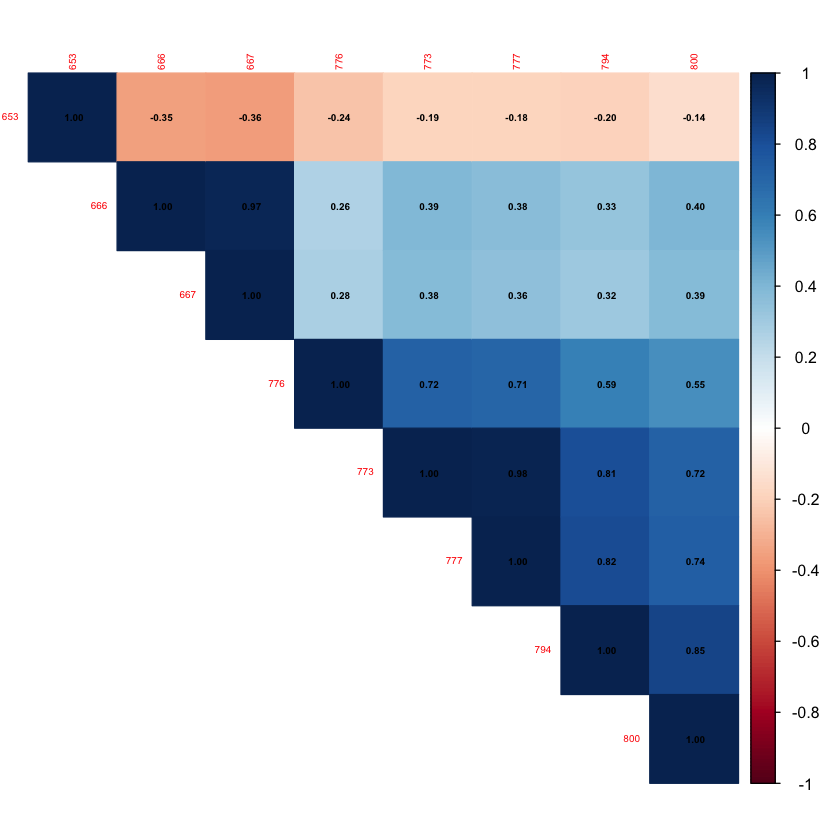

In [10]:
uni_sig <- which(log10p > p_thres)
X_sig <- X[,uni_sig]
cor_matrix <- cor(X_sig)
colnames(cor_matrix) <- uni_sig
rownames(cor_matrix) <- uni_sig
corrplot(cor_matrix, method = "color", type = "upper", order = "hclust", tl.cex = 0.5, addCoef.col = "black", number.cex = 0.5)

max_corr <- max(cor_matrix[upper.tri(cor_matrix)],na.rm = TRUE)
max_corr_index <- which(cor_matrix == max_corr, arr.ind = TRUE)
max_corr
max_corr_index

-----------------------------------------

`susieR` package provides a plot function to generate Manhattan plot for the association test results. Notice that the true effect variables are labelled in red (true effects provided to `susie_plot` via setting `b=` parameter),

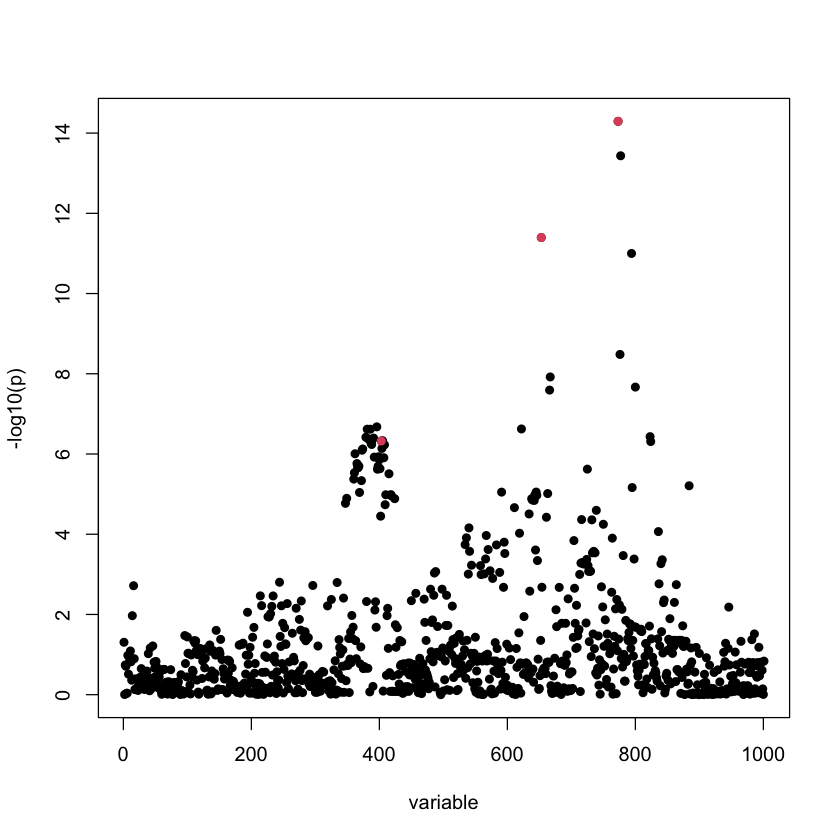

In [11]:
susie_plot(z_scores,y="z",b=b)

As shown on this plot, the "lead" SNP (the one with smallest p-value) is indeed one of the true effect variables. However, the 2nd most significant SNP is not one of the other two effect variables, and there are many other SNPs having p-values smaller than $5 \times 10^{-8}$, a widely accepted significant level threshold for genetic association studies.

-----------------------------------------

**Question 5: What index is the second most significant SNP? Is it one of the other two true effect variables? What would you say about the relationship between the top and 2nd most significant SNPs?**


**Answer:**

The index of second most significant SNP is 777. It is not a true effect variable. From the correlation analysis, the top significant SNP (#773) and the 2nd most significant SNP (#777) are highly correlated.

In [12]:
sig_pval <- log10p[which(log10p > p_thres)]
snp <- order(sig_pval, decreasing = TRUE)
uni_sig[snp[1]]
uni_sig[snp[2]]


[1] 773

[1] 777

-----------------------------------------

# "One causal variant" assumption for fine-mapping

Under the assumption that there is only one true effect in the region of interest, fine-mapping does not have to use linkage disequilibrium (LD) information between variables. It can be performed by simply calculating the likelihood of the association model for each variable separately, then computing the probability for a variable being the true effect as the ratio of its likelihood over the sum of likelihoods over all variables. We use linear regression `lm` in R to compute the log-likelihood,

In [13]:
lliks = sapply(1:ncol(X), function(i) logLik(lm(y~X[,i])))

Then compute the probability for each variable being the true effect variable: 

In [14]:
lliks = lliks - max(lliks) # To avoid taking exp on large numbers in the next line, thus improving numerical stability 
probs = exp(lliks)/sum(exp(lliks))

We use `susie_plot` function to plot these probabilities computed, and color label the true effect variables:

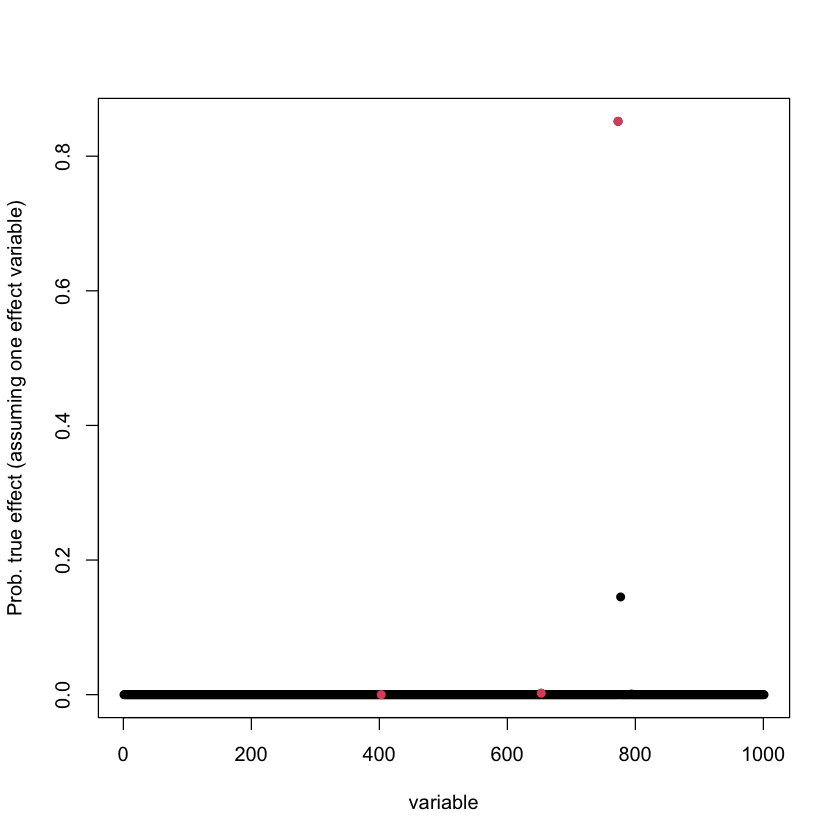

In [15]:
susie_plot(probs, y="PIP", b=b, ylab = "Prob. true effect (assuming one effect variable)")

As expected, under the "one causal variant" assumption, only the lead SNP is identified with over 80% probability of having a non-zero effect. The other two true effect variables in red are not identified.

## 95% credible set for single effect

95% credible set (CS) is defined as a set of variables with 95% probability of containing a true effect. By visually examine the plot above, we can see that the lead SNP has over 80% probability being the true effect, and another SNP near it has almost 20% probability of being the true effect. The 95% credible set should thus contain both of them in order for the coverage to exceed 95%. Indeed, we can formally verify this using an internal function `in_CS` to assess if a variable is in a single effect CS. We report the indices of these variables,

In [16]:
which(susieR:::in_CS(t(probs), coverage = 0.95) != 0)

[1] 773 777

These variables indeed correspond to the two non-zero probability variables on the plot above.

# Fine-mapping with individual level data using Sum of Single Effects model

When multiple true effects are expected, formal statistical fine-mapping via Bayesian Variable Selection
should be performed. We fit a Sum of Single Effects (SuSiE) model implemented in `susieR` package, 
assuming at most 10 causal variables (although SuSiE is robust to the choice of `L`).

In [19]:
fitted <- susie(X, y, L = 10)

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



## 95% credible sets for each single effect

By default, `susie` function computes 95% CS each containing one effect variable,

In [20]:
print(fitted$sets)

$cs
$cs$L2
[1] 653

$cs$L1
[1] 773 777

$cs$L3
 [1] 362 365 372 373 374 379 381 383 384 386 387 388 389 391 392 396 397 398 399
[20] 400 401 403 404 405 407 408 415


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L2    1.0000000     1.0000000       1.0000000
L1    0.9815726     0.9815726       0.9815726
L3    0.8686309     0.9640176       0.9720711

$cs_index
[1] 2 1 3

$coverage
[1] 0.9998236 0.9988858 0.9539811

$requested_coverage
[1] 0.95



The 3 true signals have been captured by the 3 CS reported here. The
3rd CS contains many variables, including the true causal variable
`403`. The minimum absolute correlation is 0.86.

-----------------------------------

**Question 6: Print the credible sets if we use 99% as the coverage. Hint: you may want to check the source code for `susie` function from [here](https://github.com/stephenslab/susieR)**.

**Answer:**

In [22]:
fitted_99 <- susie(X, y, L = 10, coverage = 0.99)
print(fitted_99$sets)

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



$cs
$cs$L2
[1] 653

$cs$L1
[1] 773 777

$cs$L3
 [1] 360 361 362 365 366 367 368 372 373 374 379 381 383 384 386 387 388 389 391
[20] 392 396 397 398 399 400 401 403 404 405 407 408 409 410 415 419


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L2    1.0000000     1.0000000       1.0000000
L1    0.9815726     0.9815726       0.9815726
L3    0.8310851     0.9499450       0.9556871

$cs_index
[1] 2 1 3

$coverage
[1] 0.9998236 0.9988858 0.9906629

$requested_coverage
[1] 0.99



**Question 7: does higher coverage mean you have larger CS, or smaller CS? Why is that? Please look at the 3rd CS as an example in the two fitted results, and explain why the minimum absolute correlation is lower when the coverage is higher?**

**Answer:**

Higher coverage typically means a larger CS.

**Reason**: The coverage of a CS represents the cumulative probability that it contains at least one true causal variant. For a higher converage, you need to include more variants to make sure the probability of containing the true effect reaches this higher threshold, especially when the coverage of each variant is small. Hence, the CS expands as more variants are added to meet the target coverage.

The absolute correlation measures the strength of association between SNPs. A higher correlation means the SNPs are more similar to each other in terms of genetic information, while a lower correlation means they are more independent. As the coverage increases, more SNPs are added to the credible set, including those that may have weaker correlations with the lead SNP (the SNP with the highest probability of being the true effect).

-----------------------------------

## Posterior inclusion probabilities

Here we summarize the fine-mapping results by posterior inclusion
probability (PIP):

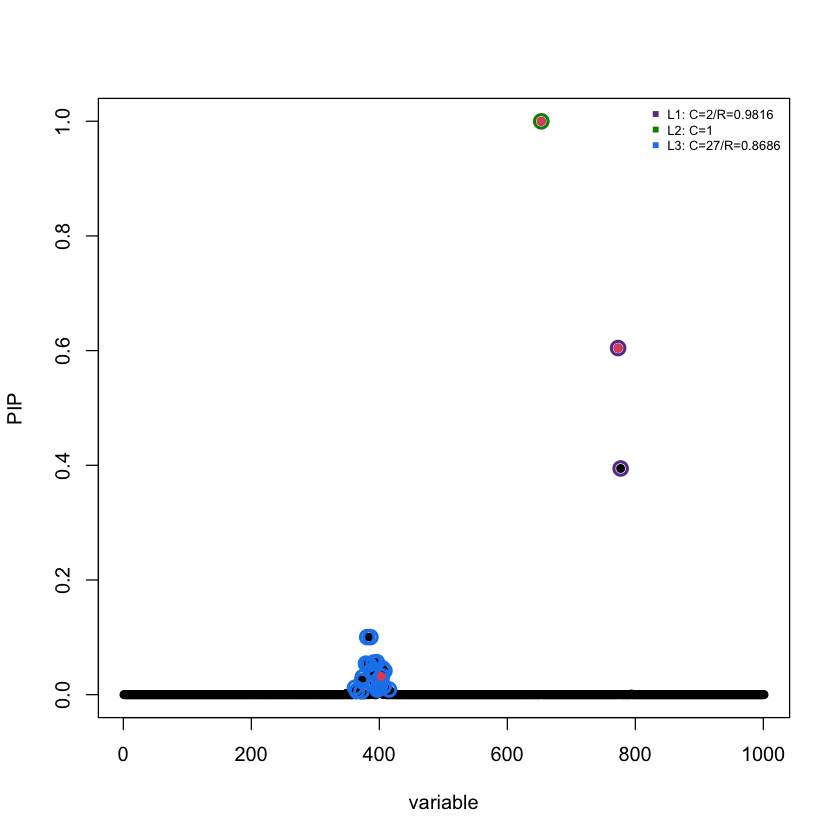

In [23]:
susie_plot(fitted, y="PIP", b=b, add_legend=T)

The true effect variables are colored red, and the three 95% CS identified are
circled in different colors. 

-------------------------------------------

**Question 8: Recall the true effect variables we know before running any susie, and for the variable 403, what is the PIP? What's the average PIP of the 3rd CS? Is the PIP for variable 403 higher or lower than the average, and why is that?**

Hint: You can use the code below to compare $-log_{10}$ p-value and PIP for the CS containing variable 403:

```R
    i  <- fitted$sets$cs$L3
    z3 <- cbind(i,log10p[i],fitted$pip[i])
    colnames(z3) <- c('position', '-log10 pvalue', 'PIP')
    z3[order(z3[,2], decreasing = TRUE),]
```

**Answer:**

The PIP for the variable 403 is 0.03199285. 

The average PIP of the 3rd CS is 0.0353326479609506. The PIP for variable 403 is slightly lower than the average. 

By rearranging the order of variants by the decreasing -log10 value, the variable 403 ranks the 10th among the total of 27 variables, which is in the middle of all variables. This suggests that the variable 403 has the medium level of association with the phenotype among all variables in CS3, which supports that the probability of variable 403 to be a true effect variable is about the average of the CS. Although #403 ranks in the first half of the CS in terms of -log10 value, the flunctuation of PIP that makes it slightly lower than the average is acceptable.

In [41]:
i  <- fitted$sets$cs$L3
z3 <- cbind(i,log10p[i],fitted$pip[i])
colnames(z3) <- c('position', '-log10 pvalue', 'PIP')
z3[order(z3[,2], decreasing = TRUE),]
z3 <- data.frame(z3)
z3[z3$position==403,] # PIP and -log10value for the variable 403
mean(z3$PIP, FUN = max) # Average PIP value for the variables

position,-log10 pvalue,PIP
396,6.676732,0.056704331
381,6.618518,0.100360243
386,6.618518,0.100360243
379,6.417587,0.054179507
391,6.396640,0.055952118
383,6.370810,0.052896918
384,6.370810,0.052896918
389,6.360493,0.042161265
405,6.331181,0.045761975
403,6.322861,0.031992848


,position,X.log10.pvalue,PIP
,<dbl>,<dbl>,<dbl>
22,403,6.322861,0.03199285


[1] 0.03533265

***

**Question 9: Please rerun the `susie` analysis setting `L=1` to detect a maximum of only one effect across the region. How does the result compare to the previous section of "one causal effect" fine-mapping using likelihoods from univariate analysis?**

**Answer:**

It coincides with the result of the previous "one causal effect" fine-mapping from univariate analysis. From the susie analysis setting L=1, we can conclude that there's a 95% or greater probability that the credible set (#773, #777) contains one effect variable. From the univariate analysis, #777 and #773 has the highest probability to be a true effect variable among all variables.

In [42]:
fitted_L1 <- susie(X, y, L = 1)
fitted_L1$sets

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



,min.abs.corr,mean.abs.corr,median.abs.corr
,<dbl>,<dbl>,<dbl>
L1,0.9815726,0.9815726,0.9815726


-------------------------------------------

## Choice of prior effect size

In SuSiE, the prior effect size is parameterized by the percentage of variance explained by a variable, $h_j^2$. 
By default, SuSiE estimates $h_j^2$ and uses it as the prior (an empirical Bayes approach). 
Here we demonstrate fixing the prior effect size to 0.2, i.e., we believe a non-zero effect variable can explain 20% variation in quantitative trait values:

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



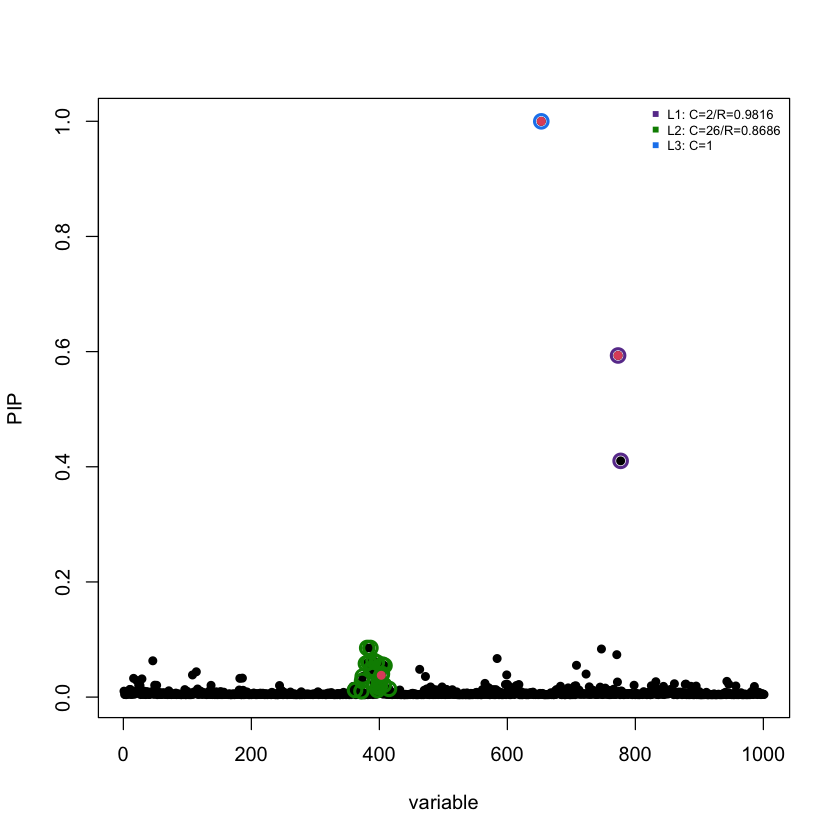

In [43]:
fitted2 = susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.2)
susie_plot(fitted2, y='PIP', b=b, add_legend=T)

The result is very similar to when prior effects are estimated. 

-------------------------------------------

**Question 10: Please change `scaled_prior_variance` to different numbers between 0 and 1, and examine the results. What happens if you set it to 0.001, and why?**

**Answer:**

I changed the `scaled_prior_variance` to be 0.001, 0.01, 0.1 and 0.5. 

When the explained variance was set to 0.1 and 0.5, the retrieved CSs are the same and similar to when prior effects are estimated. This means the chosen prior variances are reasonable. 

When the explained variance was set to 0.01, the L3 CS select 30 variables. This prior effect size generates conservative PIPs, which especially have larger effect on the variables with lower PIPs, and potentially larger credible sets.

When the explained variance was set to 0.001, no CS were found. Setting scaled_prior_variance to 0.001 suggests that you expect each non-zero effect variable to explain only 0.1% of the total variance in the trait. SuSiE treats the effects of individual variables as being very weak. This leads to a downplay potentially significant associations, resulting in lower PIPs for all variables.  This is an extremely conservative assumption, essentially telling the model that any individual effect should be negligible. As a result, the model treats all variables as having very little impact and doesn't find any variable with strong enough evidence to be included in a credible set.

In [ ]:
# Set the prior variance to 0.001
fitted3 = susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.001)
susie_plot(fitted3, y='PIP', b=b, add_legend=T)

# Set the prior variance to 0.01
fitted4 = susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.01)
susie_plot(fitted4, y='PIP', b=b, add_legend=T)

# Set the prior variance to 0.1
fitted5 = susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.1)
susie_plot(fitted5, y='PIP', b=b, add_legend=T)

# Set the prior variance to 0.5
fitted6 = susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.5)
susie_plot(fitted6, y='PIP', b=b, add_legend=T)

-------------------------------------------

# Fine-mapping with summary statistics via `susie_rss`

Summary statistics of genetic association studies typically contain effect size ($\hat{\beta}$ coefficient from regression), p-value and minor allele frequencies. 
These information can be used to perform fine-mapping with given an additional input of correlation matrix between variables.
The correlation matrix in genetics is typically referred to as LD matrix (LD for linkage disequilibrium). 
One may use external reference panels to estimate it when this matrix cannot be obtained from samples directly. There is a potential problem using LD from reference panel, and we demonstrated it in the next section.
Caution that LD matrix here has to be correlation matrix $r$, not $r^2$ or $|r|$.

We have previously computed z-scores for this data-set. The correlation matrix can be computed directly from $X$ matrix, 

In [ ]:
R <- cor(X)

SuSiE regression with summary statistics is implemented as `susie_rss` function, 

In [ ]:
fitted_rss <- susie_rss(z_scores, R, L = 10)

We compare the PIP obtained with previous analysis using individual level data,

In [ ]:
plot(fitted$pip, fitted_rss$pip, ylim=c(0,1))

The results very much agree. This is expected when the summary statistics are indeed derived from the individual level data.

## Use LD from external reference data

When original genotype information is not available, 
one may use reference panel to estimate LD matrix. 
False discoveries may occur if the LD pattern from the reference panel does not agree well with the original sample. 

To illustrate, we randomly generated 500 samples from $N(0,R)$ and treated them as reference panel genotype matrix `X_ref`.

In [ ]:
set.seed(1234)
tmp = matrix(rnorm(500*1001), 500, 1001)
eigenR = eigen(R)
eigenR$values[eigenR$values < 1e-10] = 0
X_ref = tmp %*% (eigenR$values * t(eigenR$vectors))
R_ref = cor(X_ref)

Using `susie_rss` function with LD from reference panel,

In [ ]:
fitted_rss_ref <- susie_rss(z_scores, R_ref, L = 10)
susie_plot(fitted_rss_ref, y="PIP", b=b)

-------------------------------------------

**Question 11: Please compare and comment on the CS reported using reference LD panel versus using the correct LD computed from genotype data. Are there any false discoveries?**

**Answer:**

-------------------------------------------

We recommend the following modification to the LD matrix when reference panel ($R_{ref}$) are used,
$$
\tilde{R} = \text{cov2cor}((1-w)R_{ref}+ w zz^\intercal)),
$$
where z is the original summary statistics. We suggest using $w = 1/n_{ref}$, $n_{ref}$ is the sample size from the reference panel. The modified LD matrix becomes
$$
\tilde{R} = \text{cov2cor}(\frac{n_{ref}-1}{n_{ref}}R_{ref}+ \frac{1}{n_{ref}} zz^\intercal)) = \text{cov2cor}(\frac{1}{n_{ref}}(X_{ref}^\intercal X_{ref}+ zz^\intercal)),
$$
where `X_ref` is column-standardized. This modification is implemented in `susie_rss` with parameter `z_ld_weight`:

In [ ]:
n_ref = 500
fitted_rss_ref_corrected <- susie_rss(z_scores, R_ref, z_ld_weight = 1/n_ref, L = 10)
susie_plot(fitted_rss_ref_corrected, y="PIP", b=b)

***
**Question 12: Please compare and comment on the results using adjusted reference LD panel. Is the result improved?**

**Answer:**

***

# Exercise: fine-mapping analysis on a different data-set

Please load and analyze another data-set provided in `susieR` package:

In [ ]:
rm(list=ls())
library(susieR)
data(N2finemapping)

Please use the same R code for `N3finemapping` data to analyze this new data-set, similarly focusing on the first column of the phenotype matrix as the phenotype of interest. 
This data-set contains two true effect variables. However, as you are soon to find out in univariate linear regression analysis, **the lead SNP via univariate analysis is neither of the two effect variables**.

-------------------------------------------

**Question 13: please run `susie_rss` on the N2finemapping dataset and report the results below. Does it capture any true effect variant?**

**Answer:**

-------------------------------------------

In [ ]:
sessionInfo()